In [20]:

import numpy as np
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision.datasets import MNIST, CIFAR10
from torch.utils.data import DataLoader
from torchvision import transforms
from matplotlib import pyplot as plt
import os
from torchvision.utils import make_grid
from google.colab import drive
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


In [2]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

data_set = CIFAR10('.', download=True, transform=transforms.ToTensor())

images = data_set.data
images = torch.tensor(data_set.data.reshape(images.shape[0], -1, images.shape[1], images.shape[2]), device=device)
labels = data_set.classes

batch_size = 128
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

dataloader = DataLoader(
    CIFAR10('.', download=False, transform=transform),
    batch_size=batch_size,
    shuffle=True)


torch.backends.cudnn.benchmark = True


Extracting ./cifar-10-python.tar.gz to .


In [3]:

class Generator(torch.nn.Module):

  def __init__(self, in_dim=10, im_channel=3):
    super(Generator, self).__init__()

    self.generator = torch.nn.Sequential(
        torch.nn.ConvTranspose2d(in_channels=in_dim, out_channels=2048, kernel_size=4, stride=2),
        torch.nn.BatchNorm2d(2048),
        torch.nn.ReLU(),

        torch.nn.ConvTranspose2d(in_channels=2048, out_channels=1024, kernel_size=4, stride=1),
        torch.nn.BatchNorm2d(1024),
        torch.nn.ReLU(),

        torch.nn.ConvTranspose2d(in_channels=1024, out_channels=512, kernel_size=3, stride=2),
        torch.nn.BatchNorm2d(512),
        torch.nn.ReLU(),

        torch.nn.ConvTranspose2d(in_channels=512, out_channels=im_channel, kernel_size=4, stride=2),
        torch.nn.Tanh()
        # torch.nn.Sigmoid()

    )

  def forward(self, image):
    return self.generator(image)

  



In [4]:

z_dim = 100
generator = Generator(in_dim=z_dim, im_channel=3).to(device=device)
noise = torch.randn(1, z_dim, 1, 1, device=device)
a = generator(noise)


In [5]:

# Try softmax later ****
class Discriminator(torch.nn.Module):
    def __init__(self, in_channel=3):
      super(Discriminator, self).__init__()
      self.discrimator = torch.nn.Sequential(
          torch.nn.Conv2d(in_channels=in_channel, out_channels=512, kernel_size=4, stride=2),
          torch.nn.BatchNorm2d(512),
          torch.nn.LeakyReLU(negative_slope=0.2),

          torch.nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=4, stride=2),
          torch.nn.BatchNorm2d(1024),
          torch.nn.LeakyReLU(negative_slope=0.2),

          torch.nn.Conv2d(in_channels=1024, out_channels=2048, kernel_size=4, stride=1),
          torch.nn.BatchNorm2d(2048),
          torch.nn.LeakyReLU(negative_slope=0.2),

          torch.nn.Conv2d(in_channels=2048, out_channels=1, kernel_size=3, stride=1)
      )

    def forward(self, image):
      return self.discrimator(image)


In [6]:

z_dim = 100
generator = Generator(in_dim=z_dim, im_channel=3).to(device=device)
noise = torch.randn(1, z_dim, 1, 1, device=device)
a = generator(noise)

discriminator = Discriminator(in_channel=3).to(device=device)
discriminator(a).shape


torch.Size([1, 1, 1, 1])

In [7]:


def get_noise(n_samples, z_dim):
    return torch.randn(n_samples, z_dim, 1, 1, device=device)

def get_one_hot(labels, nb_classes):
  return torch.reshape(torch.nn.functional.one_hot(labels, nb_classes), (len(labels), nb_classes, 1, 1)).to(device=device)

def get_generator_input(noise, one_hot):
  return torch.cat((noise, one_hot), dim=1)

def get_discirminator_input(images, one_hot):
  one_hot_matrix = torch.ones((len(images), 10, 32, 32), device=device) * one_hot
  return torch.cat((images, one_hot_matrix), dim=1)

def show_tensor_images(image_tensor, num_images=25, size=(1, 32, 32), nrow=5, show=True):
    '''
    Function for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in an uniform grid.
    '''
    image_tensor = (image_tensor + 1) / 2
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:num_images], nrow=nrow)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    if show:
        plt.show()


In [9]:

z_dim = 128
lr = 0.0002
generator = Generator(in_dim=z_dim+10, im_channel=3).to(device=device)
generator_opt = torch.optim.Adam(generator.parameters(), lr=lr)
discriminator = Discriminator(in_channel=13).to(device)
discriminator_opt = torch.optim.Adam(discriminator.parameters(), lr=lr)

# You initialize the weights to the normal distribution
# with mean 0 and standard deviation 0.02
def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)
generator = generator.apply(weights_init)
discriminator = discriminator.apply(weights_init)


In [ ]:

cur_step = 0
display_step = 391
generator_losses = []
discriminator_losses = []

# Training
epochs = 30
for epoch in range(epochs):
  for real_images, classes in tqdm(dataloader):
    
    noise = get_noise(len(classes), z_dim)
    one_hot = get_one_hot(classes, nb_classes=10)
    
    # Train discriminator
    discriminator_opt.zero_grad()
    generator_input = get_generator_input(noise, one_hot)
    fake_images = generator(generator_input).detach()
    real_images = real_images.to(device).detach()
    discriminator_fake_input = get_discirminator_input(fake_images, one_hot)
    discriminator_real_input = get_discirminator_input(real_images, one_hot)
    
    fake_pred = discriminator(discriminator_fake_input).view(-1,1)
    real_pred = discriminator(discriminator_real_input).view(-1,1)
    disc_fake_loss = torch.nn.BCEWithLogitsLoss()(fake_pred, torch.zeros_like(fake_pred))
    disc_real_loss = torch.nn.BCEWithLogitsLoss()(real_pred, torch.ones_like(real_pred))

    disc_loss = (disc_fake_loss + disc_real_loss) / 2
    disc_loss.backward(retain_graph=True)
    discriminator_opt.step()

    discriminator_losses += [disc_loss.item()]

    # Train generator
    generator_opt.zero_grad()
    fake_images = generator(generator_input)
    discriminator_fake_input = get_discirminator_input(fake_images, one_hot)
    fake_pred = discriminator(discriminator_fake_input).view(-1,1)
    gen_loss = torch.nn.BCEWithLogitsLoss()(fake_pred, torch.ones_like(fake_pred))
    gen_loss.backward()
    generator_opt.step()

    generator_losses += [gen_loss.item()]

    if cur_step % display_step == 0 and cur_step > 0:
      gen_mean = sum(generator_losses[-display_step:]) / display_step
      disc_mean = sum(discriminator_losses[-display_step:]) / display_step
      print(f"Epoch {epoch+1} - Step {cur_step}: Generator loss: {gen_mean}, discriminator loss: {disc_mean}")
      show_tensor_images(fake_images)
      show_tensor_images(real_images)
      step_bins = 20
      x_axis = sorted([i * step_bins for i in range(len(generator_losses) // step_bins)] * step_bins)
      num_examples = (len(generator_losses) // step_bins) * step_bins
      plt.plot(
          range(num_examples // step_bins), 
          torch.Tensor(generator_losses[:num_examples]).view(-1, step_bins).mean(1),
          label="Generator Loss"
      )
      plt.plot(
          range(num_examples // step_bins), 
          torch.Tensor(discriminator_losses[:num_examples]).view(-1, step_bins).mean(1),
          label="Discriminator Loss"
      )
      plt.legend()
      plt.show()
    cur_step += 1



In [ ]:

def show_tensor_images(image_tensor, num_images=25, size=(1, 32, 32), nrow=5, show=True):
    '''
    Function for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in an uniform grid.
    '''
    image_tensor = (image_tensor + 1) / 2
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:num_images], nrow=nrow)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    if show:
        plt.show()
        


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # This is added back by InteractiveShellApp.init_path()


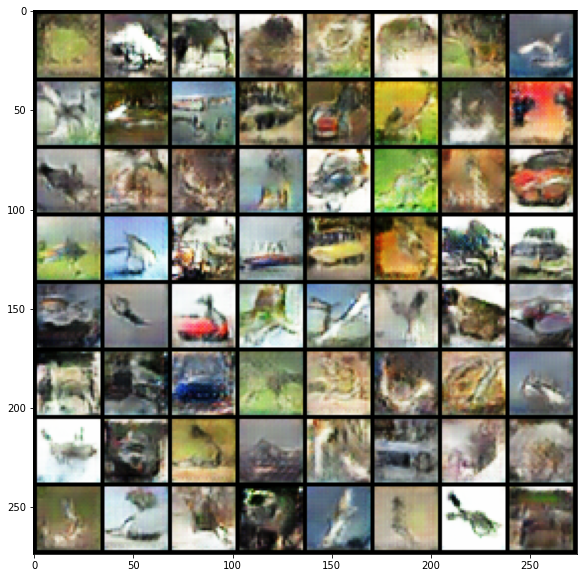

In [24]:

models = torch.load("/content/drive/MyDrive/Colab Notebooks/conditional_DGAN_CIFAR.pt")
generator = Generator(in_dim=z_dim+10, im_channel=3).to(device=device)
generator.load_state_dict(models["generator_state_dict"])
generator.eval()

n_images = 64
z_dim = 128
z = get_noise(n_images, z_dim)
labels = torch.randint(0, 10, (1, n_images)).view(n_images)
labels = torch.tensor(labels)
one_hot = get_one_hot(labels, 10)
gen_input = get_generator_input(z, one_hot)
generated_img = generator(gen_input)
plt.figure(figsize=(10,10))
show_tensor_images(generated_img, num_images=n_images, size=(1, 32, 32), nrow= int(np.sqrt(n_images)))


In [26]:
torch.save({
    "generator":  generator,
    "discriminator": discriminator
}, "./model.pt")

